## 0. Libraries and Personal Tools

In [39]:
import sys
from os.path import abspath

from multiprocessing import cpu_count

from gc import collect

In [40]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the default figure size and theme to display good looking matplotlib plots.
rcParams["figure.figsize"] = (10, 6)
plt.style.use("fivethirtyeight")

In [41]:
# add absolute path from root to sys.path to use custom modules
sys.path.insert(0, abspath('..'))

from src.models.train_model import BaseModel

## 1. Build Base Model

In [42]:
base_model = BaseModel()
base_model.read_config("../models/config.yaml")
features, target = base_model.get_data()
base_model.build_base_pipeline()

In [43]:
from pandas.core.frame import DataFrame
DataFrame(base_model.base_pipeline.fit_transform(base_model.data.sample(frac=0.1, random_state=777))).isna().sum().sum()

0

## 2. Parameter Optimization

### 2.1. Split Data

In [44]:
from src.utils import create_kf_groups

from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, GroupKFold
from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

In [45]:
from sklearn.model_selection import GroupShuffleSplit

gsp = GroupShuffleSplit(n_splits=2, test_size=0.20, random_state=777)
train_index, test_index = next(gsp.split(base_model.data, groups=base_model.data.index.get_level_values("game_num")))

X_train = base_model.data[features].iloc[train_index]
y_train = base_model.data[target].iloc[train_index]

X_test = base_model.data[features].iloc[test_index]
y_test = base_model.data[target].iloc[test_index]

### 2.2. Define Parameter Grid

In [46]:
if base_model.config["model"]["ipca"]["batch_size"] == "auto":
    TOTAL_IPCA_BATCHES = 50
    ipca_batch = int(round(len(X_train) / TOTAL_IPCA_BATCHES, -3))
else:
    ipca_batch = base_model.config["model"]["ipca"]["batch_size"]
ipca_batch

34000

In [47]:
base_model.base_pipeline.steps.append((
    "ipca", 
    IncrementalPCA(
        n_components=base_model.config["model"]["ipca"]["n_components"], 
        batch_size=ipca_batch,
        whiten=base_model.config["model"]["ipca"]["whiten"]
        ),
    ))


In [48]:
search_spaces = {
        "xgb__n_estimators": Integer(200, 400),
        "xgb__learning_rate": Real(0.05, 0.15, "uniform"),
        "xgb__max_depth": Integer(4, 6),
        "xgb__gamma": Real(0.05, 0.10, "uniform"),
        "xgb__subsample": Real(0.6, 0.8, "uniform"),
        "xgb__colsample_bytree": Real(0.8, 1.0, "uniform"),
    }

In [49]:
xgb_model = XGBClassifier(objective="binary:logistic")

In [50]:
base_model.base_pipeline.steps.append(("xgb", xgb_model))

### 2.3. Define K-Group-Folds

In [51]:
n_folds = 5

game_num = X_train.index.get_level_values("game_num")
groups = create_kf_groups(game_num, n_folds=n_folds)

gkf = GroupKFold(n_splits=n_folds)

In [52]:
groups.value_counts()

a    342325
b    341751
c    336117
d    335230
e    341351
dtype: int64

In [53]:
base_model.base_pipeline

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('player',
                                                 ColumnTransformer(transformers=[('demolished',
                                                                                  PlayerDemolished(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb40ca5280>),
                                                                                 ('position',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(fill_value=0.0,
                                                                                                                 strategy='constant')),
                                                                                                  ('scaler',
                                                                                                   MinMaxScaler())]),
                                                                                  <sklearn.com...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, ...))])

### 2.4. Hyperparameters - Bayesian Optimization

In [54]:
# Kudos to: Luca Massaron
# Source: https://www.kaggle.com/code/lucamassaron/tutorial-bayesian-optimization-with-xgboost
# https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV
# https://github.com/fmfn/BayesianOptimization

import warnings
warnings.filterwarnings("ignore")

bayes_opt = BayesSearchCV(
    estimator=base_model.base_pipeline, 
    search_spaces=search_spaces, 
    n_iter=50,
    pre_dispatch="2*n_jobs",
    n_jobs=cpu_count(), 
    iid=False,
    verbose=2, 
    scoring="neg_log_loss",
    optimizer_kwargs={'base_estimator': 'GP'},
    cv=GroupKFold(n_splits=n_folds).split(X_train, y_train, groups=groups),
    random_state=777,
    )

In [55]:
overdone_control = DeltaYStopper(delta=0.001)

In [56]:
import pprint
from time import time

def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [57]:
best_params = report_perf(bayes_opt, X_train, y_train,'XGBoost', callbacks=[overdone_control])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
XGBoost took 59875.30 seconds,  candidates checked: 5, best CV score: -0.201 ± 0.002
Best parameters:
OrderedDict([('xgb__colsample_bytree', 0.9696901563520837),
             ('xgb__gamma', 0.07561613263590211),
             ('xgb__learning_rate', 0.06776244440430806),
             ('xgb__max_depth', 6),
             ('xgb__n_estimators', 351),
             ('xgb__subsample', 0.68900406443721)])



## 3. Validation

In [62]:
best_model_params = dict()
for param, value in dict(best_params).items():
    best_model_params[param.split("__")[1]] = value

In [63]:
best_model_params

{'colsample_bytree': 0.9696901563520837,
 'gamma': 0.07561613263590211,
 'learning_rate': 0.06776244440430806,
 'max_depth': 6,
 'n_estimators': 351,
 'subsample': 0.68900406443721}

In [64]:
base_model = BaseModel()
base_model.read_config("../models/config.yaml")
features, target = base_model.get_data()
base_model.build_base_pipeline()

best_xgb_model = XGBClassifier(**best_model_params)

base_model.base_pipeline.steps.append((
    "ipca", 
    IncrementalPCA(
        n_components=base_model.config["model"]["ipca"]["n_components"], 
        batch_size=ipca_batch,
        whiten=base_model.config["model"]["ipca"]["whiten"]
        ),
    ))

base_model.base_pipeline.steps.append(("xgb", best_xgb_model))

In [65]:
best_model = base_model.base_pipeline.fit(X_train, y_train)

In [66]:
from joblib import dump
dump(best_model, "../models/xgboost_ipca_10perc.joblib")

['../models/xgboost_ipca_10perc.joblib']

In [67]:
from json import dump
with open("../models/xgboost_ipca_10perc.json", "w") as f:
    dump(best_model_params, f)

In [68]:
preds = best_model.predict_proba(X_test)[:,1]

In [69]:
from sklearn.metrics import log_loss
log_loss(y_test, preds)

0.19699712853555074

In [70]:
import numpy as np
import seaborn as sns
from pandas.core.frame import DataFrame, Series
from pandas import concat
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

# Kudos to: Mateus Coelho
# https://www.kaggle.com/code/mateuscco/how-to-evaluate-model-calibration/notebook

def ece(y_test, preds, strategy = 'uniform'):
    df = DataFrame({'target': y_test, 'proba': preds, 'bin': np.nan})
    
    if(strategy == 'uniform'):
        lim_inf = np.linspace(0, 0.9, 10)
        for idx, lim in enumerate(lim_inf):
            df.loc[df['proba'] >= lim, 'bin'] = idx

    elif(strategy == 'quantile'):
        pass
    
    df_bin_groups = concat([df.groupby('bin').mean(), df['bin'].value_counts()], axis = 1)
    df_bin_groups['ece'] = (df_bin_groups['target'] - df_bin_groups['proba']).abs() * (df_bin_groups['bin'] / df.shape[0])
    return df_bin_groups['ece'].sum()

def make_report(y_test, preds):
    # Computing AUC
    auc = roc_auc_score(y_test, preds)
    display(f'AUROC: {auc}')
    display(f'AUROC: {2*auc-1}')
    display(f'Fraction of positive cases in the test set: {y_test.mean()}')
    display(f'Mean predicted value in the test set:       {preds.mean()}')
    display(f'ECE (equal width bins):       {ece(y_test, preds)}')
    
    # Plotting probabilities
    display('#### Histogram of the probability distribution')
    Series(preds).hist(bins = 40)
    plt.show()
    
    # Plotting KDE by class
    display('#### KDE plots of the probability distribution by class')
    fig, ax1 = plt.subplots()
    sns.kdeplot(preds[y_test == 0], label = 'No goal', ax = ax1)
    ax2 = ax1.twinx()
    sns.kdeplot(preds[y_test == 1], label = 'Goal within 10s', color = 'red', ax = ax2)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.show()
    
    # Plotting calibration
    display('#### Calibration curve (equal width bins)')
    fop, mpv = calibration_curve(y_test, preds, n_bins=10)
    plt.plot(mpv, fop, "s-", label='model')
    plt.plot([0,1],[0,1], label='ideal')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.legend()
    plt.show()
    
    display('#### Calibration curve (equal size bins)')
    fop, mpv = calibration_curve(y_test, preds, n_bins=10, strategy='quantile')
    plt.plot(mpv, fop, "s-", label='model')
    plt.plot([0,1],[0,1], label='ideal')
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.legend()
    plt.show()

'AUROC: 0.7155305220705643'

'AUROC: 0.43106104414112867'

'Fraction of positive cases in the test set: 0.05609659793497561'

'Mean predicted value in the test set:       0.05736232548952103'

'ECE (equal width bins):       0.0017074993254635566'

'#### Histogram of the probability distribution'

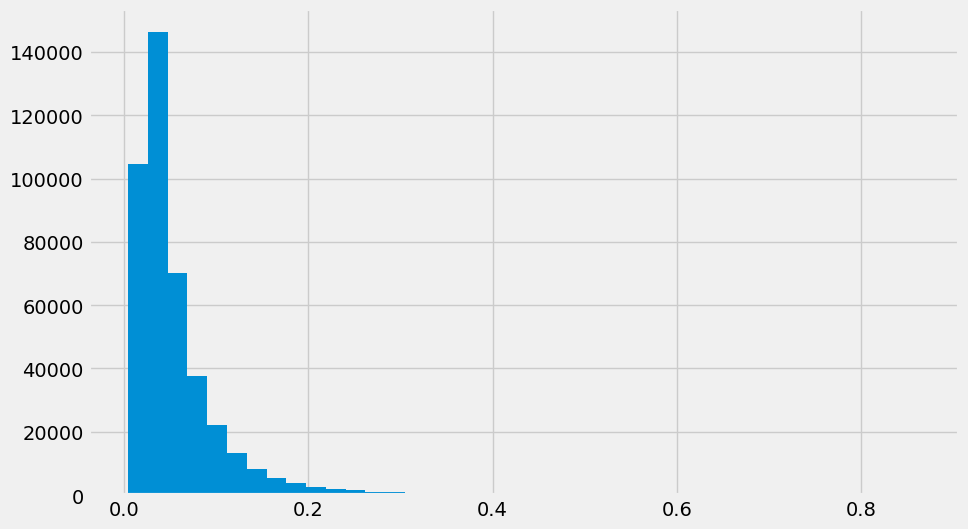

'#### KDE plots of the probability distribution by class'

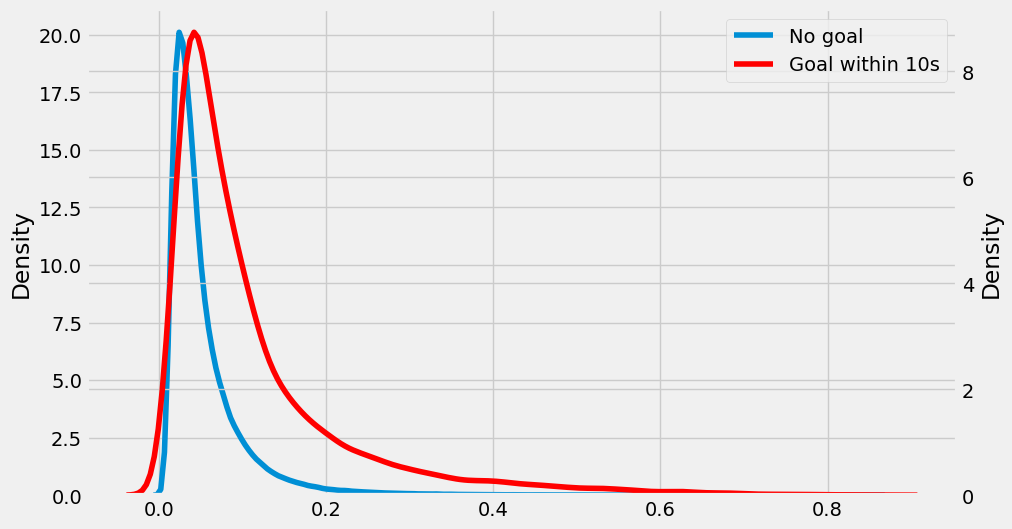

'#### Calibration curve (equal width bins)'

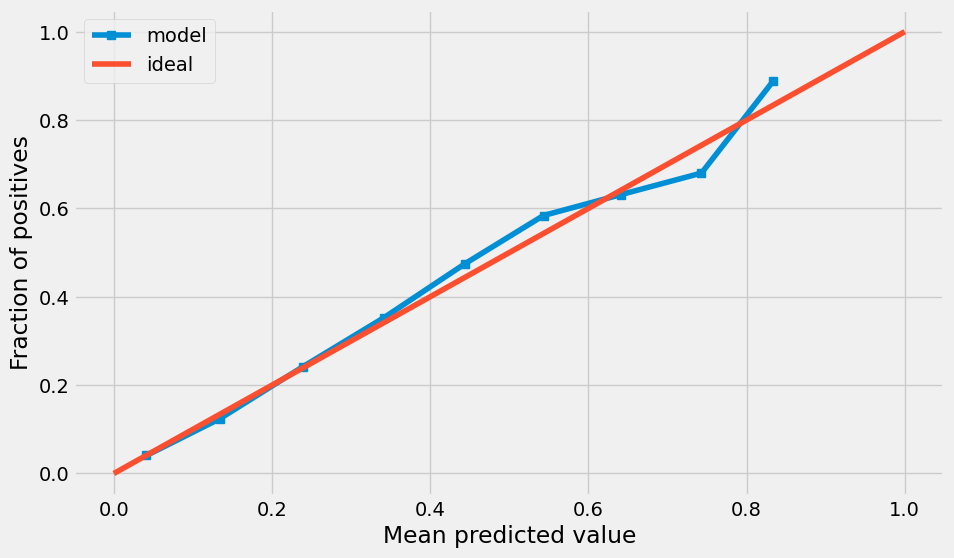

'#### Calibration curve (equal size bins)'

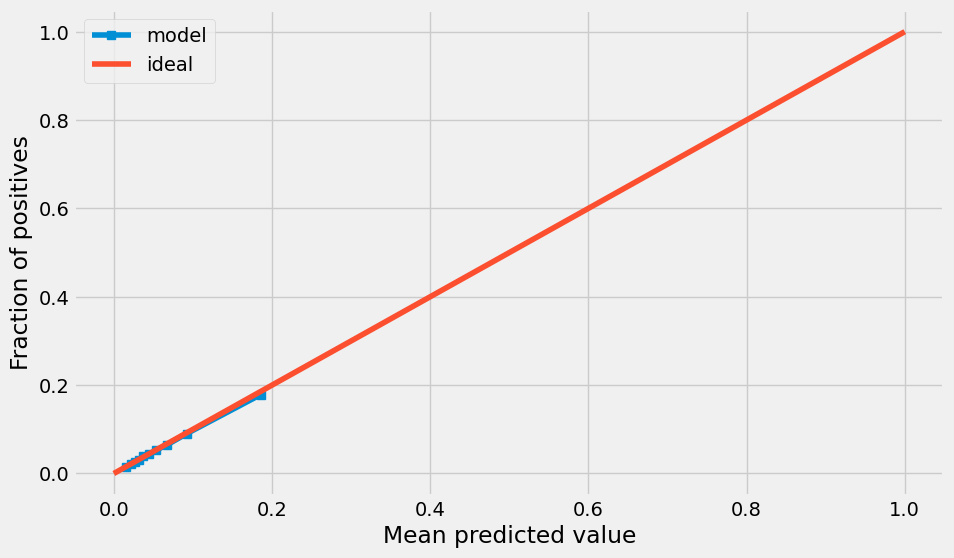

In [71]:
make_report(y_test, preds)